C:\Users\34739\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


运行设备: cuda
输出目录: ./output
数据集加载: E:\\HW2\\X-ray肺炎检测数据集\train - 5216 张影像
数据集加载: E:\\HW2\\X-ray肺炎检测数据集\val - 16 张影像
数据集加载: E:\\HW2\\X-ray肺炎检测数据集\test - 624 张影像
训练集规模: 5216
验证集规模: 16
测试集规模: 624


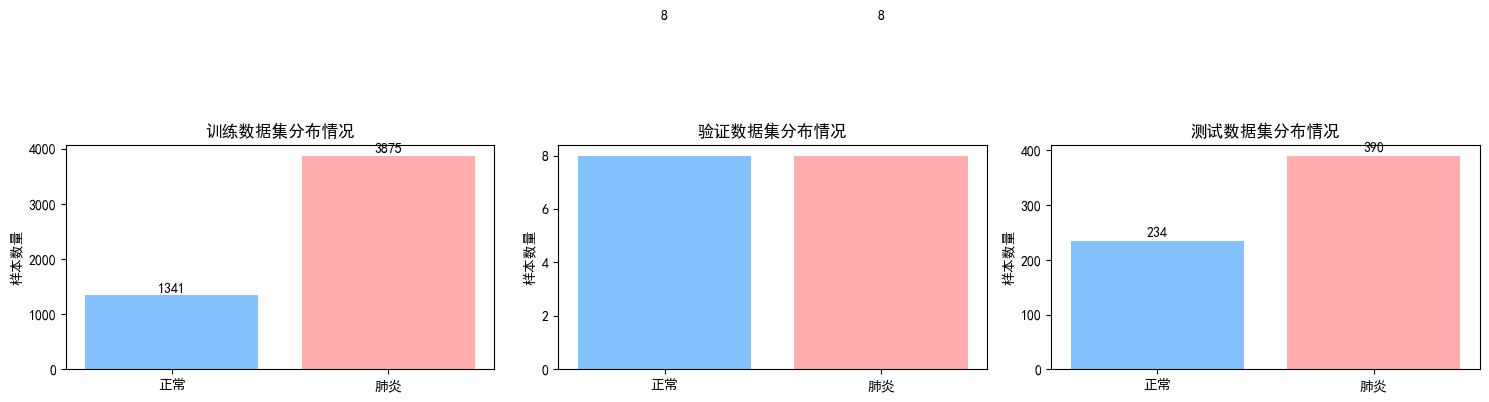

创建模型: resnet34, 类别数: 2
开始模型训练...
训练周期 1/20
--------------------------------------------------
训练损失: 0.2250 准确率: 0.9074
验证损失: 0.3946 准确率: 0.8750
验证精确率: 1.0000 召回率: 0.7500 F1: 0.8571

保存最佳模型: ./output/best_model.pth
训练周期 2/20
--------------------------------------------------
训练损失: 0.1553 准确率: 0.9404
验证损失: 0.8440 准确率: 0.5625
验证精确率: 0.5333 召回率: 1.0000 F1: 0.6957

训练周期 3/20
--------------------------------------------------
训练损失: 0.1483 准确率: 0.9465
验证损失: 1.5416 准确率: 0.5625
验证精确率: 0.5333 召回率: 1.0000 F1: 0.6957

训练周期 4/20
--------------------------------------------------
训练损失: 0.1335 准确率: 0.9492
验证损失: 0.6097 准确率: 0.7500
验证精确率: 0.6667 召回率: 1.0000 F1: 0.8000

训练周期 5/20
--------------------------------------------------
训练损失: 0.1233 准确率: 0.9528
验证损失: 0.1907 准确率: 1.0000
验证精确率: 1.0000 召回率: 1.0000 F1: 1.0000

保存最佳模型: ./output/best_model.pth
训练周期 6/20
--------------------------------------------------
训练损失: 0.1341 准确率: 0.9546
验证损失: 1.3162 准确率: 0.5625
验证精确率: 0.5333 召回率: 1.0000 F1: 0.6957

训练周期 7/20

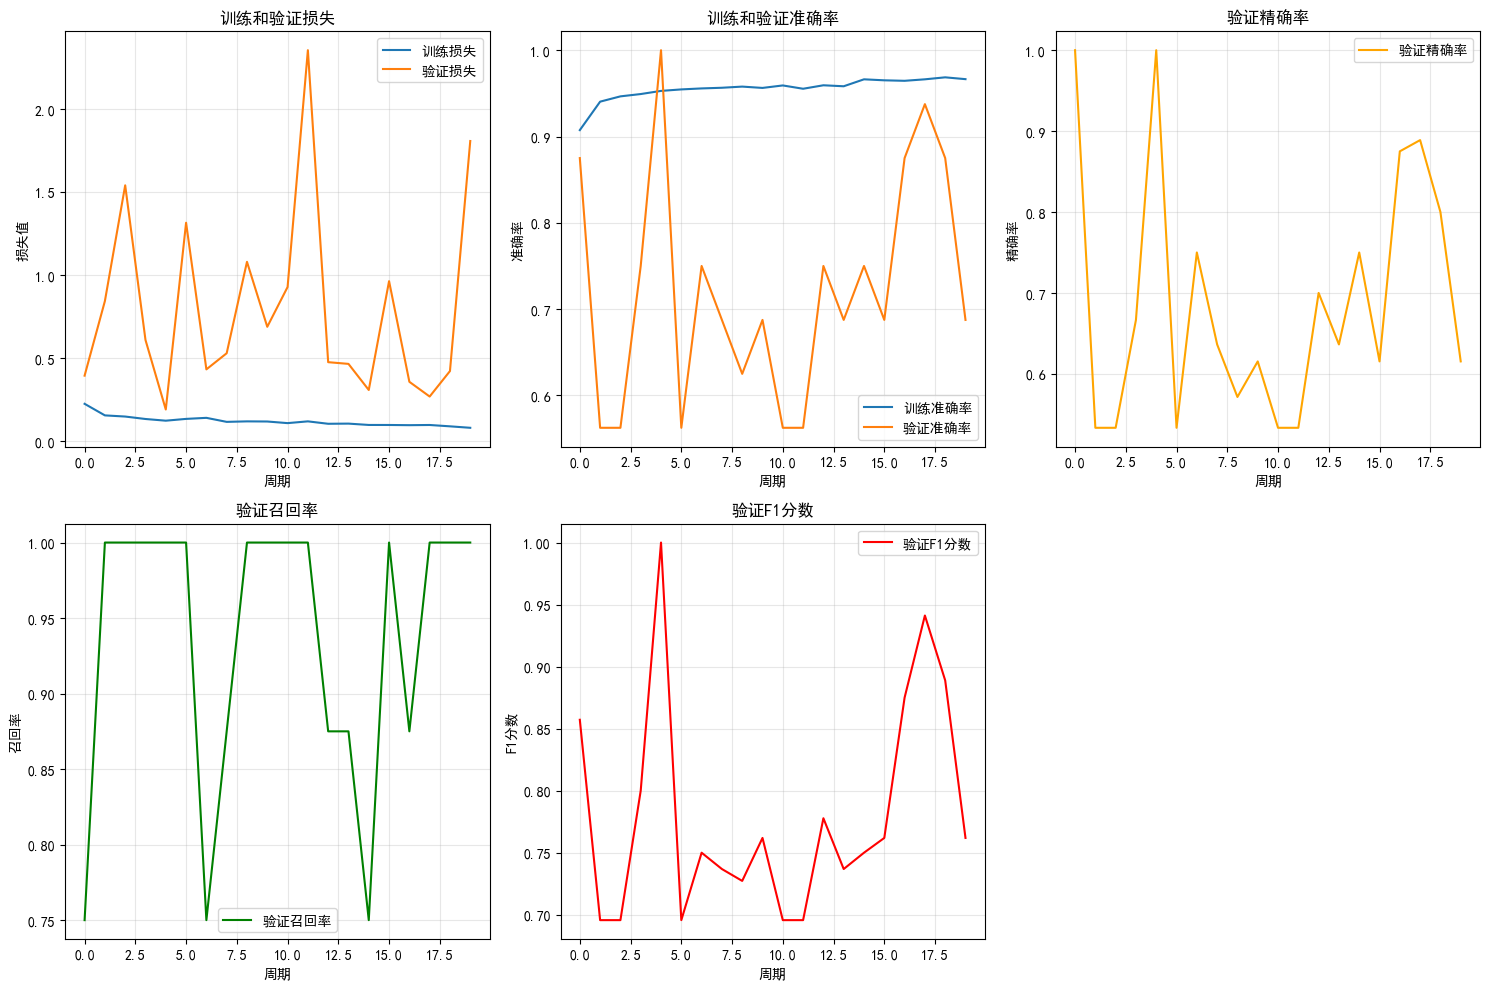

模型测试结果分析
整体准确率: 0.8446
精确率指标: 0.8021
召回率指标: 0.9974
F1综合分数: 0.8891

详细分类报告:
              precision    recall  f1-score   support

          正常       0.99      0.59      0.74       234
          肺炎       0.80      1.00      0.89       390

    accuracy                           0.84       624
   macro avg       0.90      0.79      0.81       624
weighted avg       0.87      0.84      0.83       624



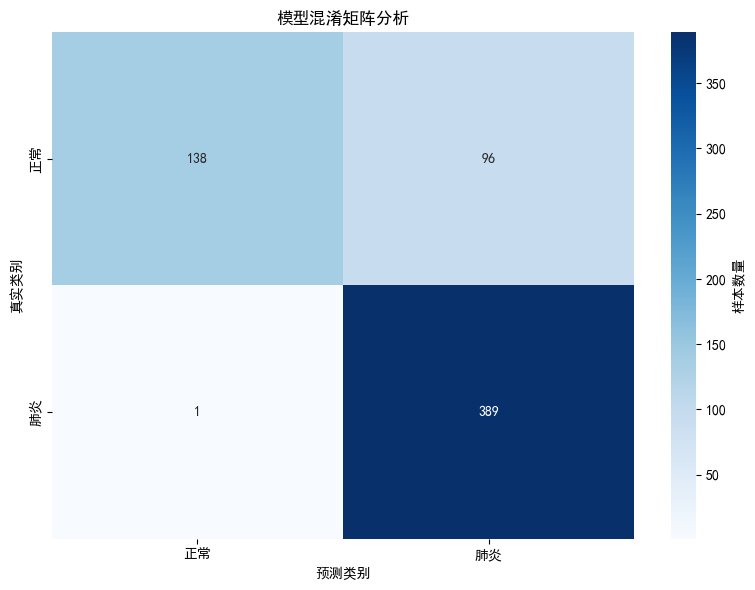

正确分类样本数: 527
错误分类样本数: 97


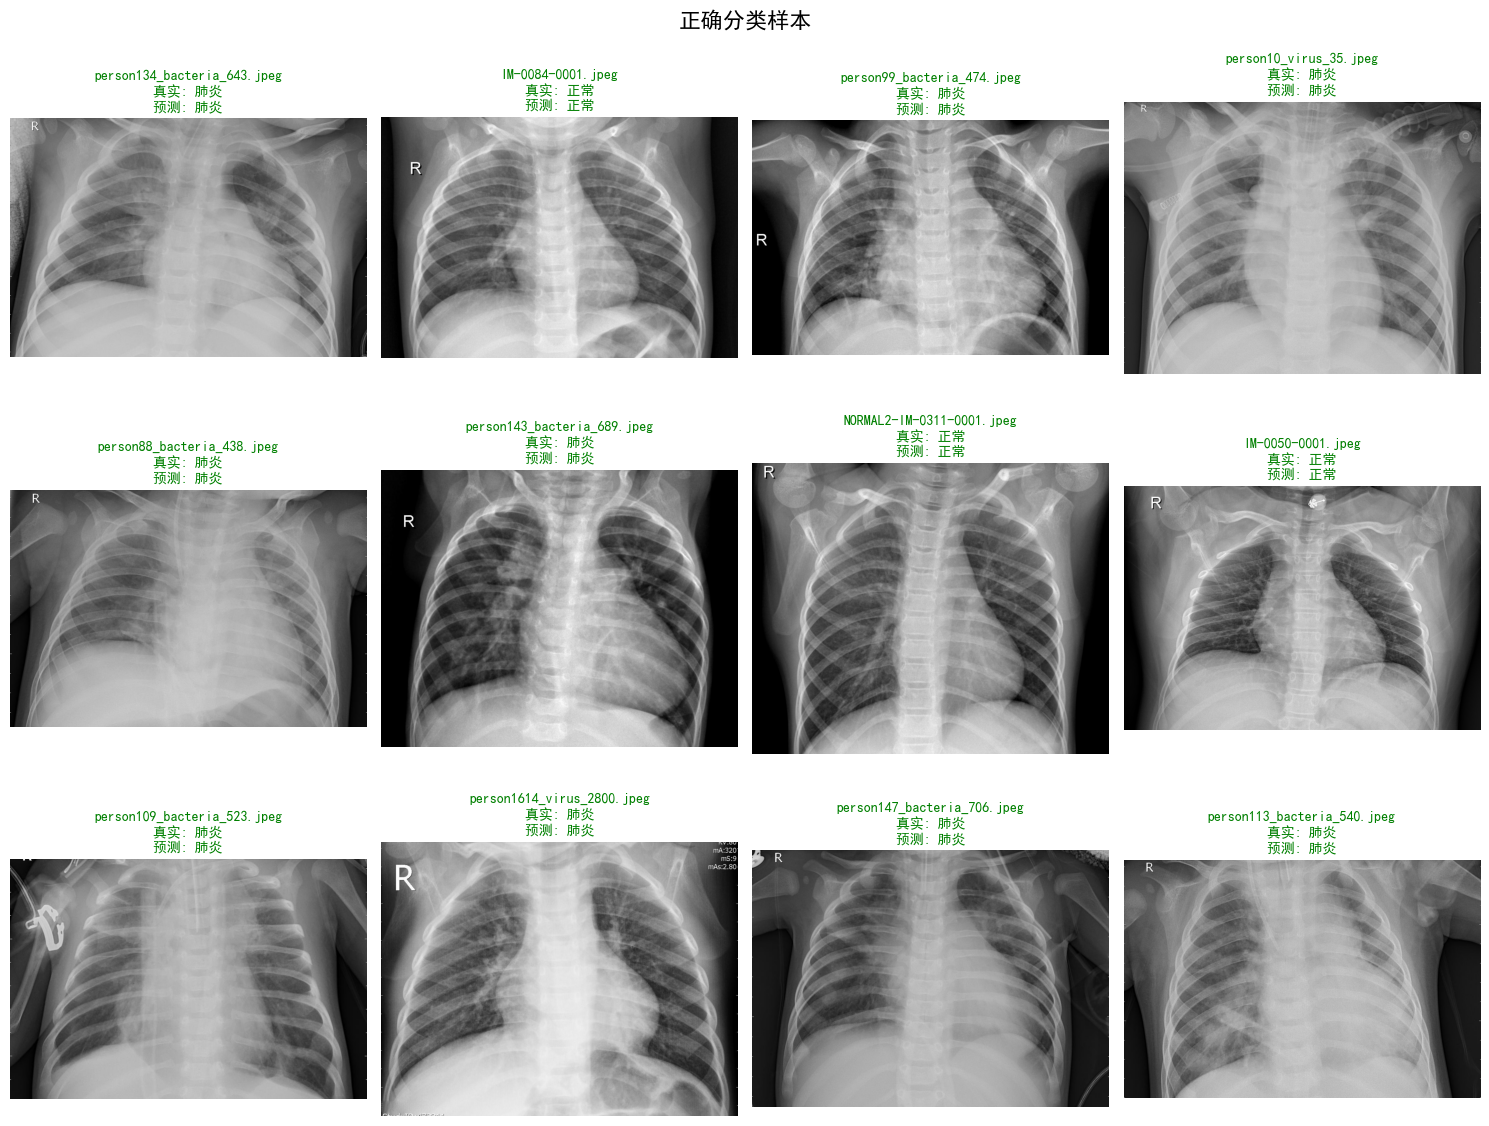

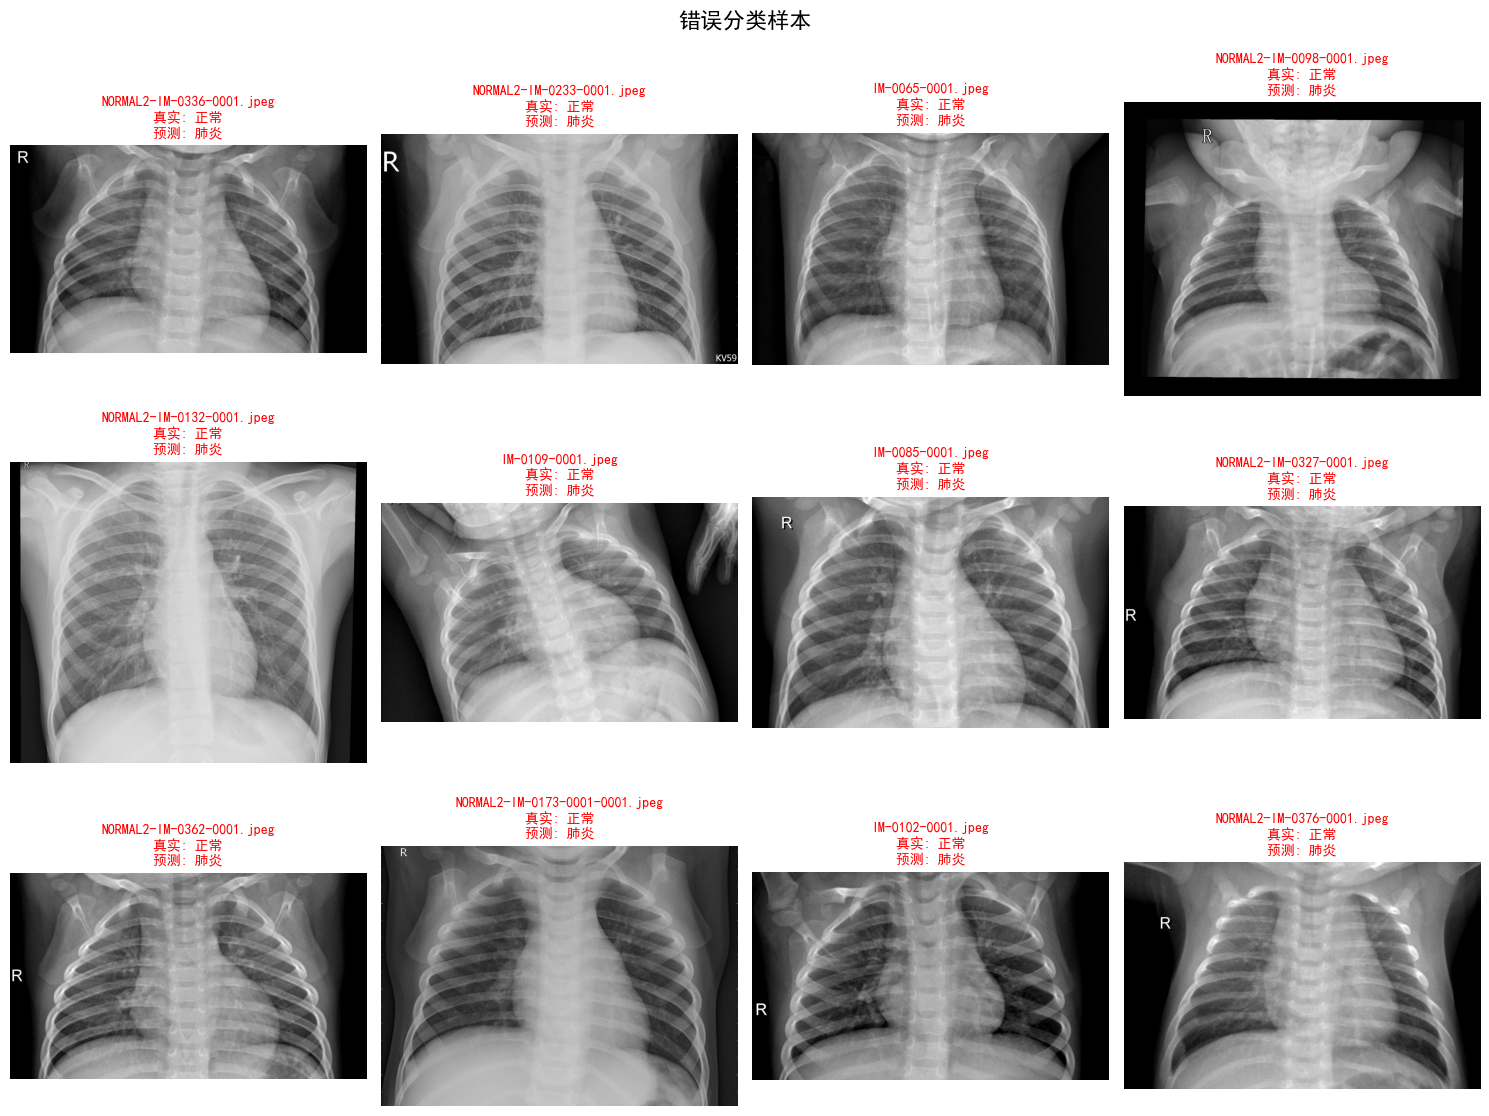


生成类激活图...
正确分类样本: 527
错误分类样本: 97


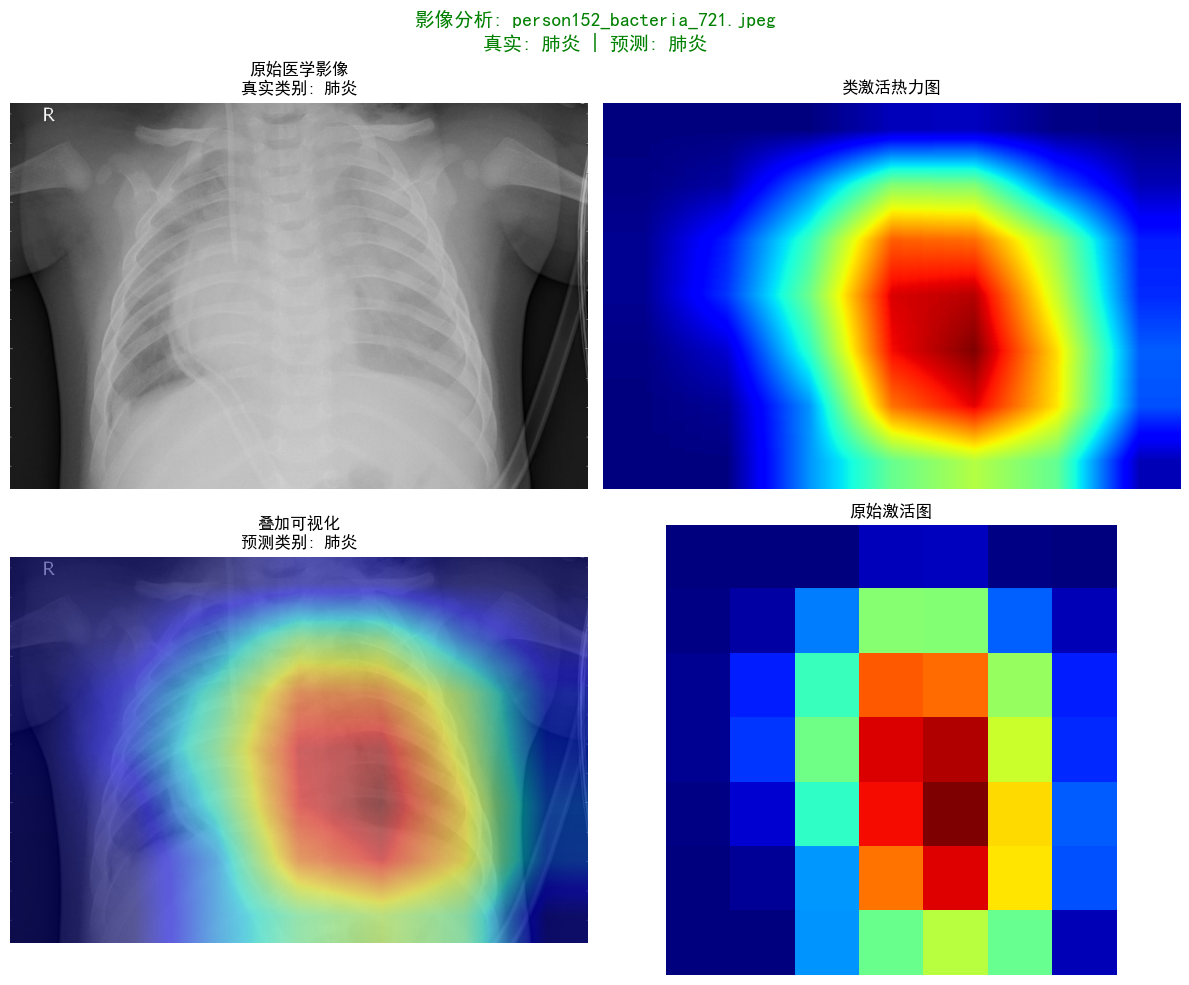


影像分析: person152_bacteria_721.jpeg
高激活区域比例: 0.1020
诊断分析: 检测到明显的肺炎特征区域
--------------------------------------------------


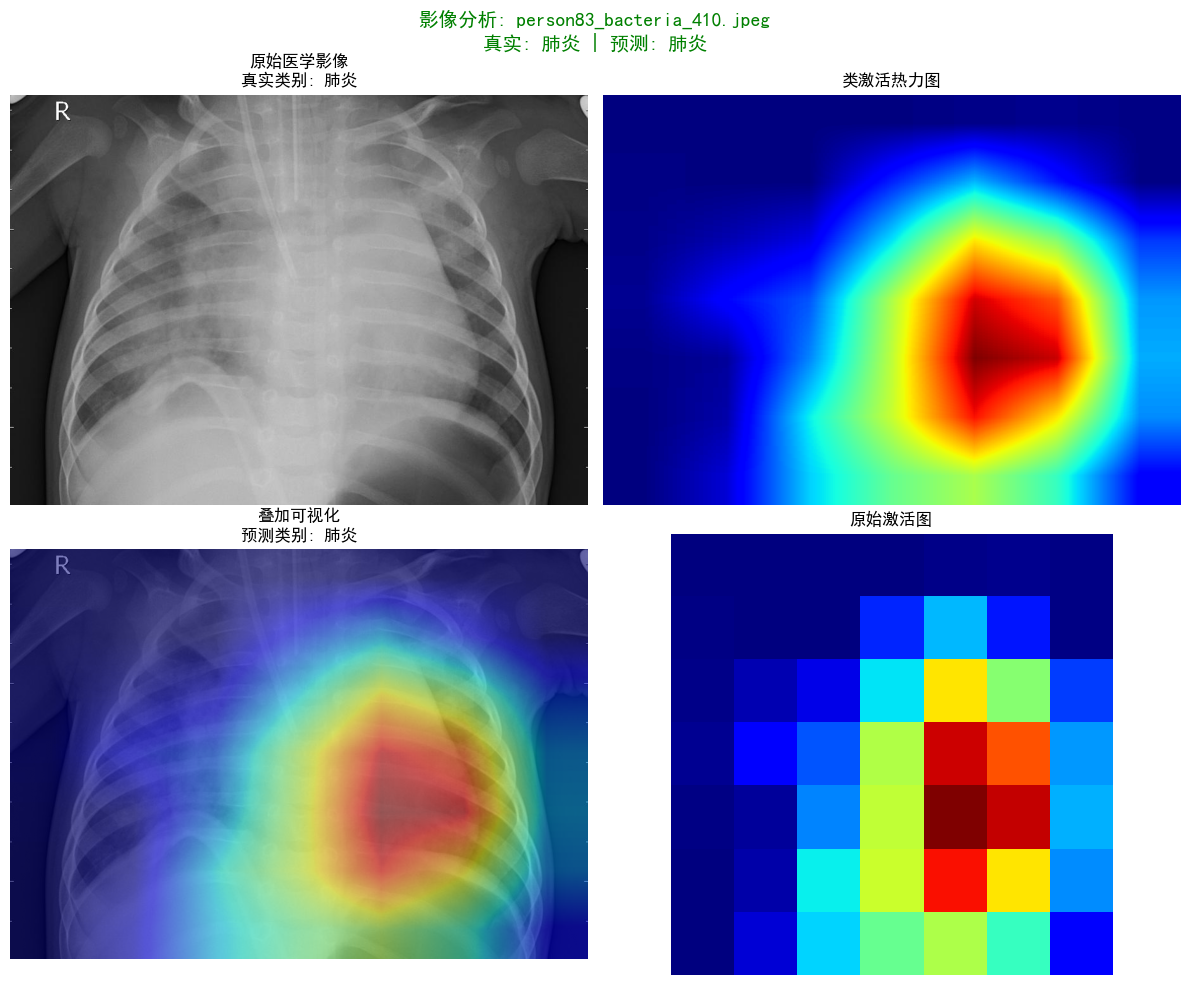


影像分析: person83_bacteria_410.jpeg
高激活区域比例: 0.1020
诊断分析: 检测到明显的肺炎特征区域
--------------------------------------------------


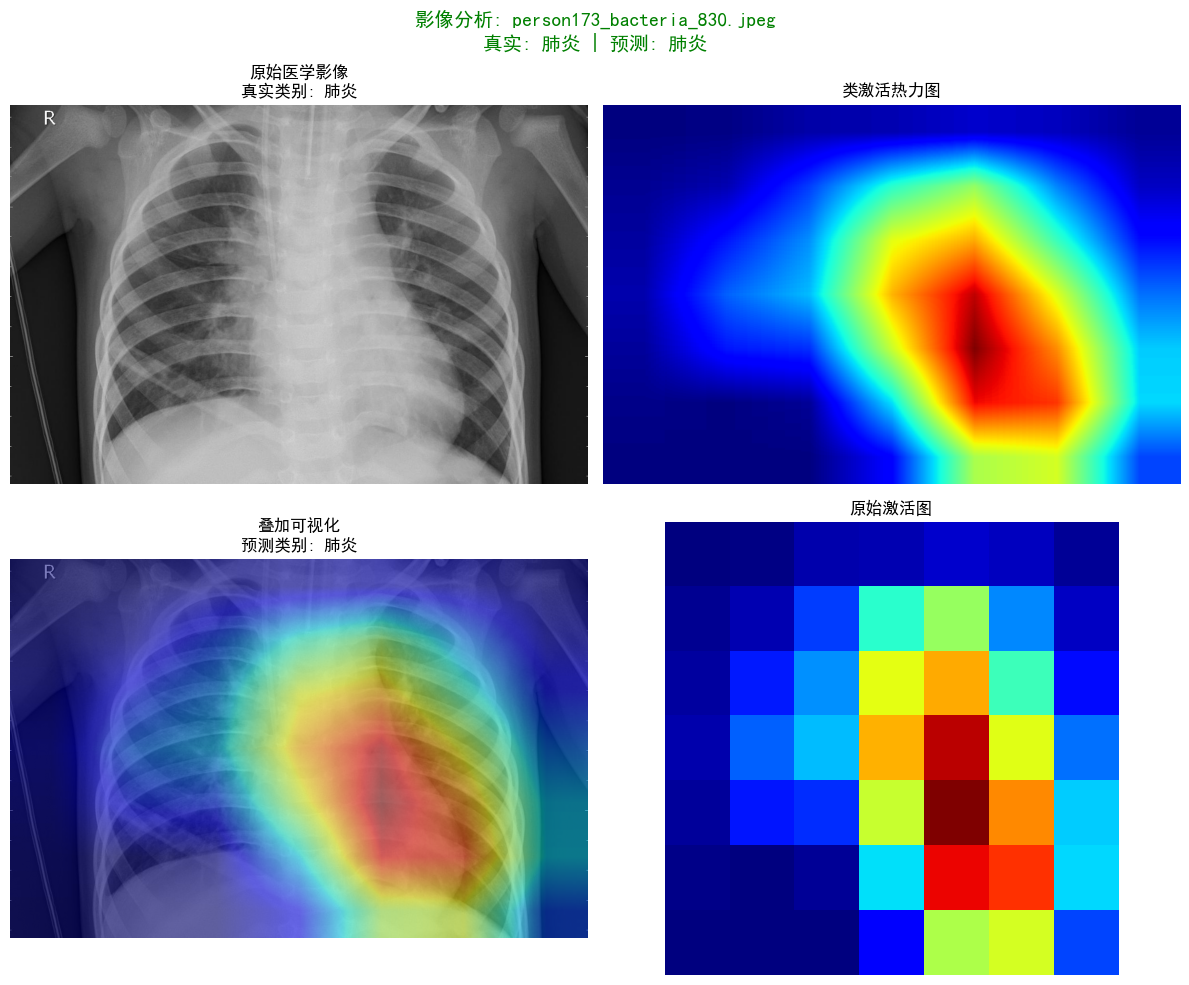


影像分析: person173_bacteria_830.jpeg
高激活区域比例: 0.1020
诊断分析: 检测到明显的肺炎特征区域
--------------------------------------------------


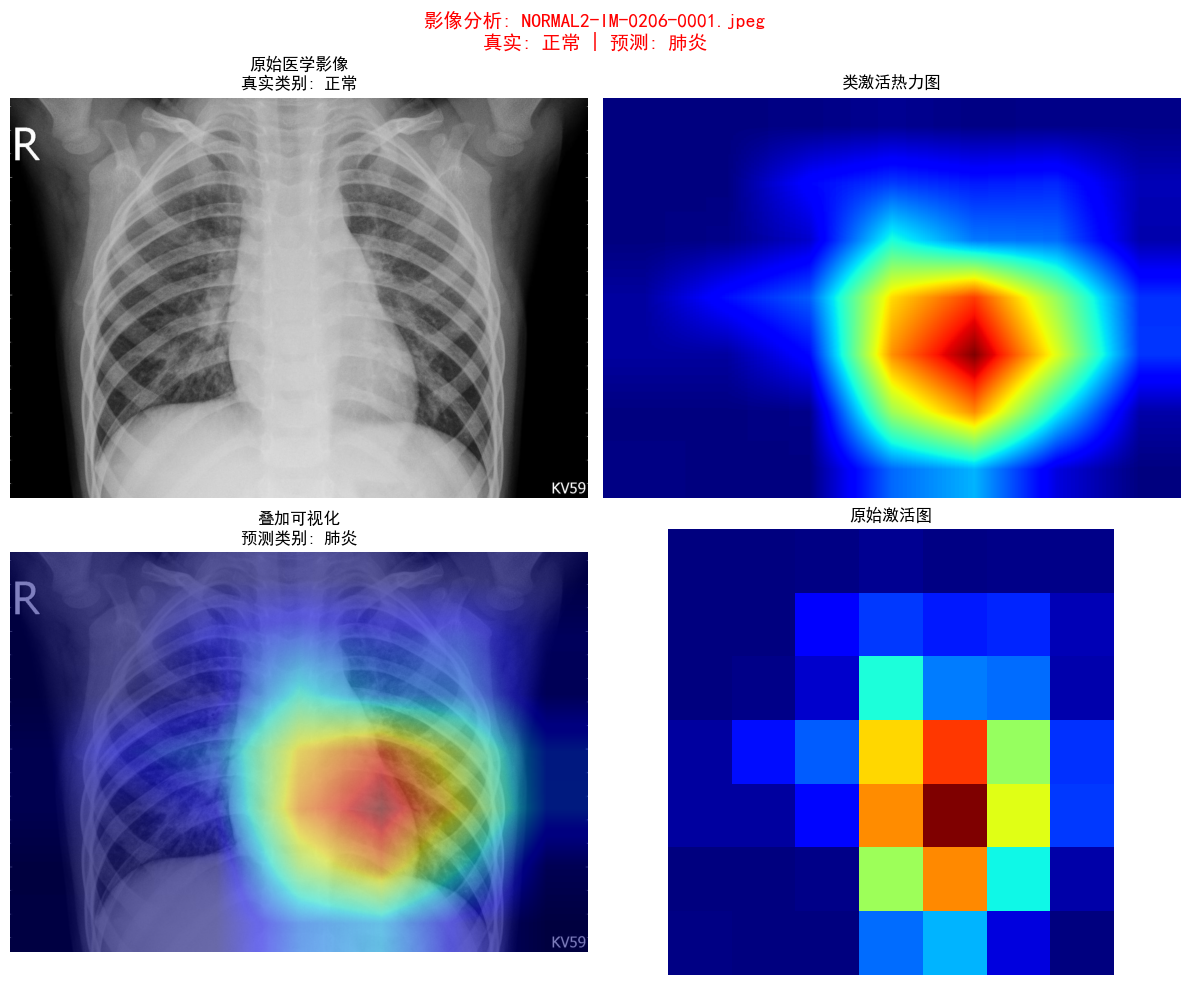


影像分析: NORMAL2-IM-0206-0001.jpeg
高激活区域比例: 0.1020
诊断分析: 检测到明显的肺炎特征区域
--------------------------------------------------


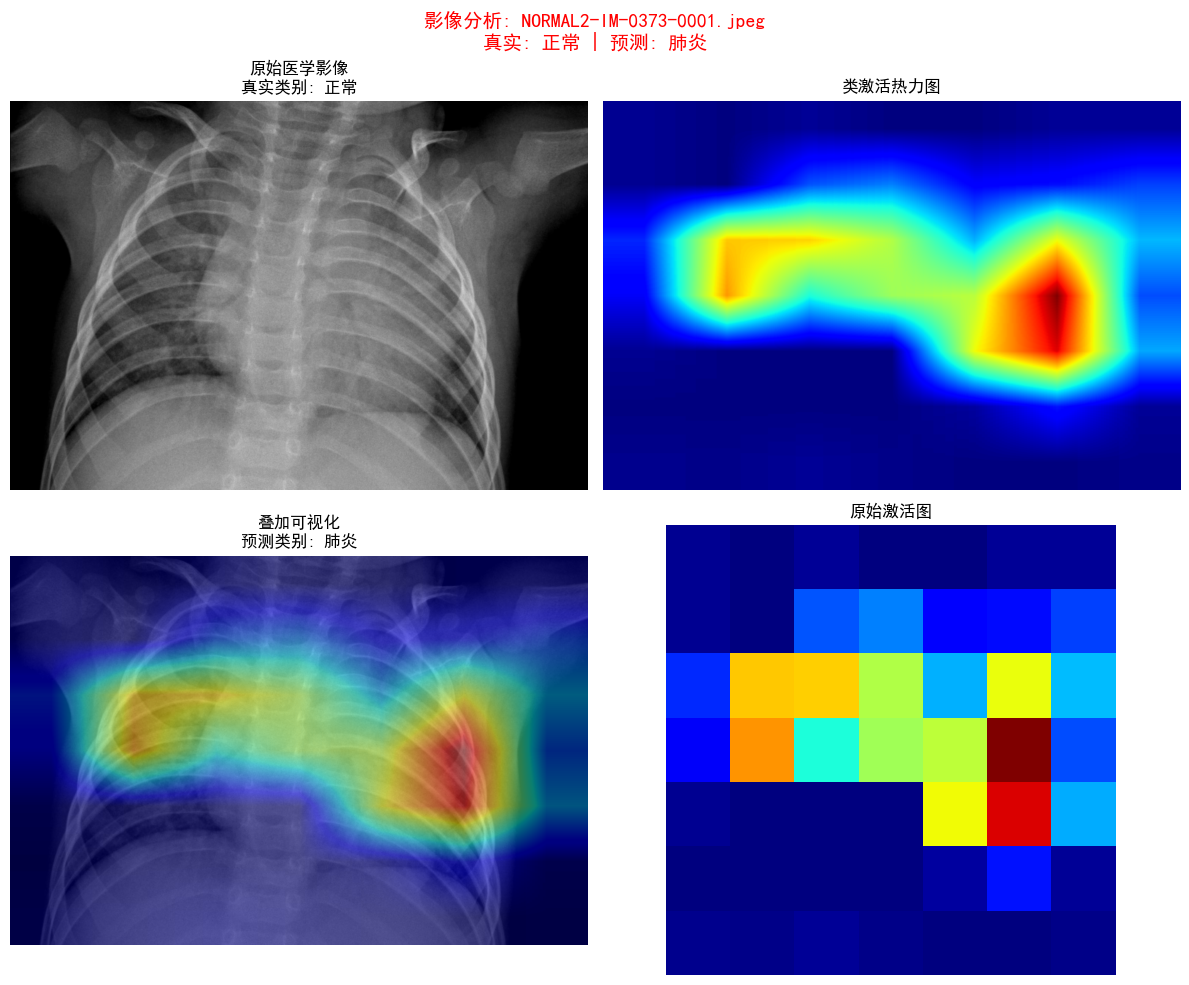


影像分析: NORMAL2-IM-0373-0001.jpeg
高激活区域比例: 0.1020
诊断分析: 检测到明显的肺炎特征区域
--------------------------------------------------


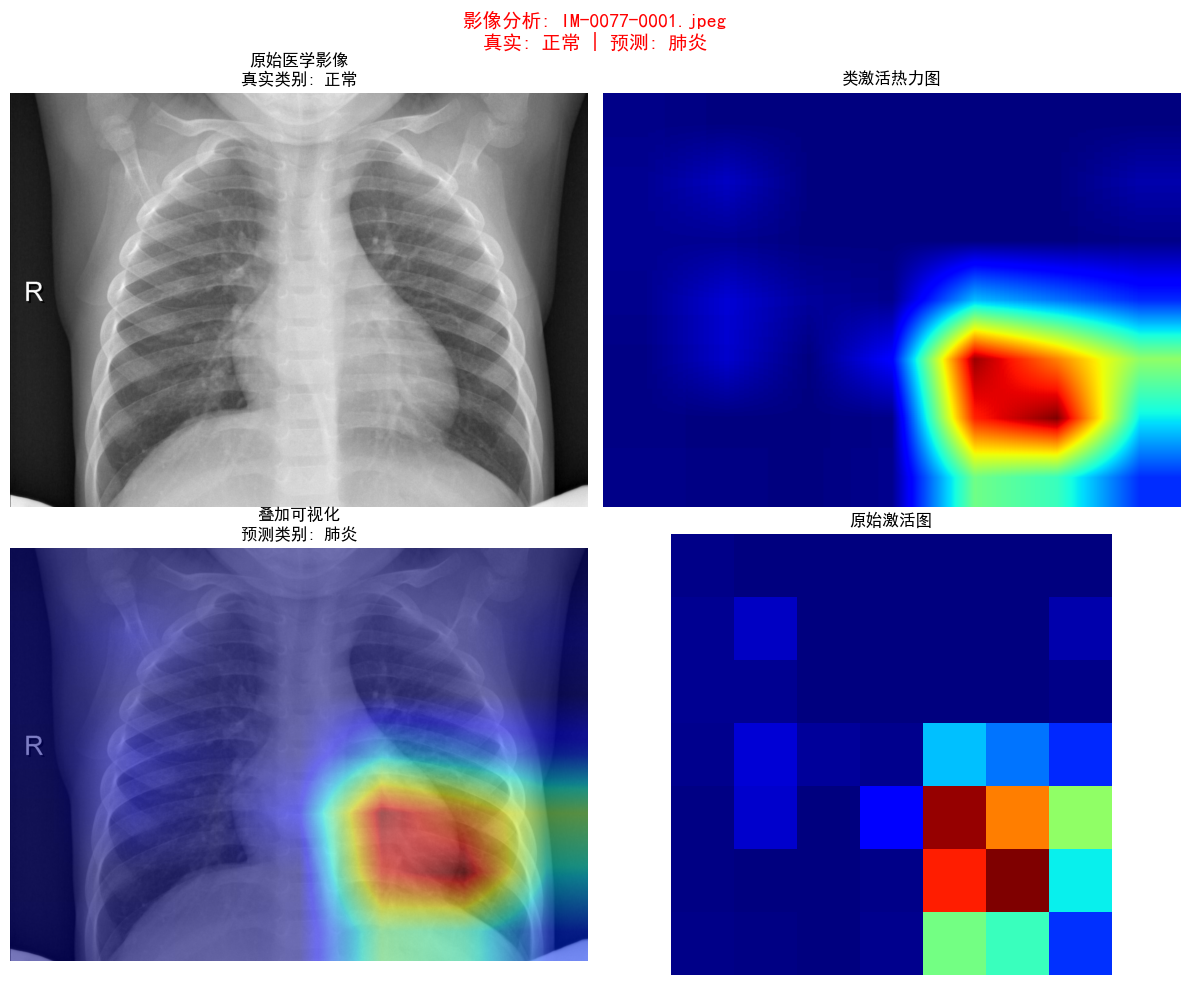


影像分析: IM-0077-0001.jpeg
高激活区域比例: 0.1020
诊断分析: 检测到明显的肺炎特征区域
--------------------------------------------------

医学影像分析流程完成！
最终测试准确率: 0.8446
详细结果保存至: ./output/
操作 耗时: 1819.9050 秒


In [ ]:
"""主程序"""
import os
from config.settings import Config
from data.dataset import DataLoaderManager
from models.classifier import ModelFactory
from training.trainer import ModelTrainer
from training.evaluator import ModelEvaluator
from visualization.plots import PlotManager
from visualization.cam import CAMVisualizer

from utils import Timer 

def main():
    """主函数"""
    # 初始化配置
    Config.setup_environment()
    timer = Timer()
    timer.__enter__()

    # 检查数据路径
    if not os.path.exists(Config.DATA_ROOT):
        print(f"数据路径不存在: {Config.DATA_ROOT}")
        return
    
    try:
        # 创建数据加载器
        train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = \
            DataLoaderManager.create_data_loaders(Config.DATA_ROOT)
        
        print(f"训练集规模: {len(train_dataset)}")
        print(f"验证集规模: {len(val_dataset)}")
        print(f"测试集规模: {len(test_dataset)}")
        
        # 可视化数据分布
        PlotManager.plot_class_distribution(train_dataset, val_dataset, test_dataset)
        
        # 创建模型
        model = ModelFactory.create_model()
        
        # 训练模型
        trainer = ModelTrainer(model, train_loader, val_loader)
        trained_model, training_metrics = trainer.train()
        
        # 评估模型
        evaluator = ModelEvaluator(trained_model, test_loader)
        results = evaluator.evaluate()
        
        # 可视化结果
        confusion_mat = PlotManager.plot_confusion_matrix(
            results['true_labels'], 
            results['predictions']
        )
        
        # 可视化样本预测
        PlotManager.plot_sample_predictions(
            test_loader,
            results['predictions'],
            results['true_labels'], 
            results['image_names']
        )
        
        # 可视化CAM
        print("\n生成类激活图...")
        cam_visualizer = CAMVisualizer(trained_model)
        cam_visualizer.visualize_samples(
            test_dataset,
            results['predictions'],
            results['true_labels'],
            results['image_names']
        )
        
        # 保存结果
        evaluator.save_results(results, confusion_mat, f'{Config.OUTPUT_DIR}/evaluation_report.txt')
        
        print("\n医学影像分析流程完成！")
        print(f"最终测试准确率: {results['accuracy']:.4f}")
        print(f"详细结果保存至: {Config.OUTPUT_DIR}/")
        
    except Exception as e:
        print(f"流程执行失败: {e}")
        raise

    timer.__exit__()


if __name__ == "__main__":
    main()